In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.parser import parse


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [43]:
df = pd.read_excel('df1.xlsx')

In [29]:
df.tail(5)

,Year,Real GDP growth rate
28,2014,0.059837
29,2015,0.066793
30,2016,0.062108
31,2017,0.068122
32,2018,0.066000


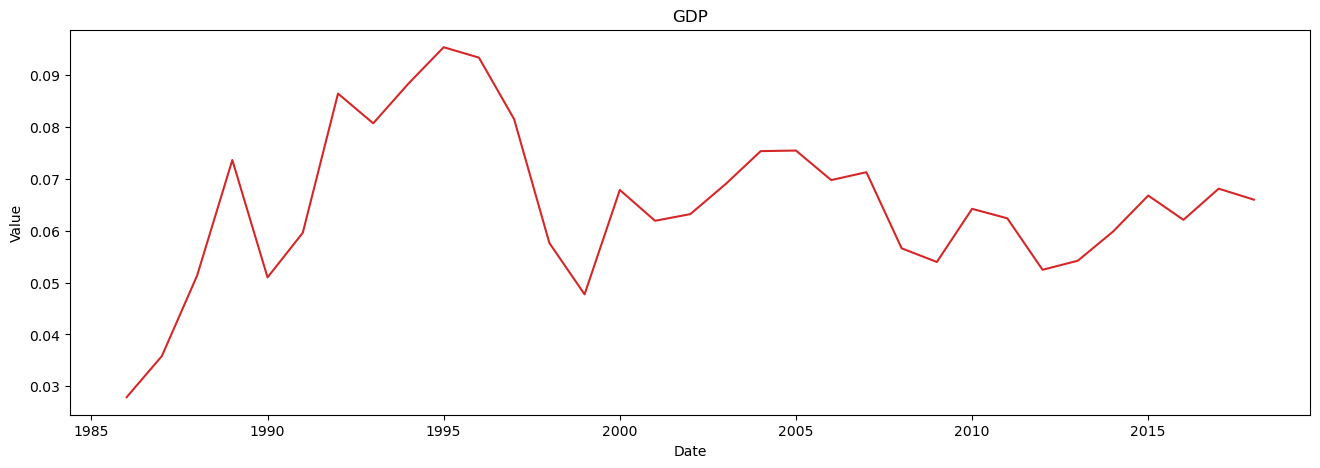

In [14]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df, x=df['Year'], y=df['Real GDP growth rate'], title='GDP')

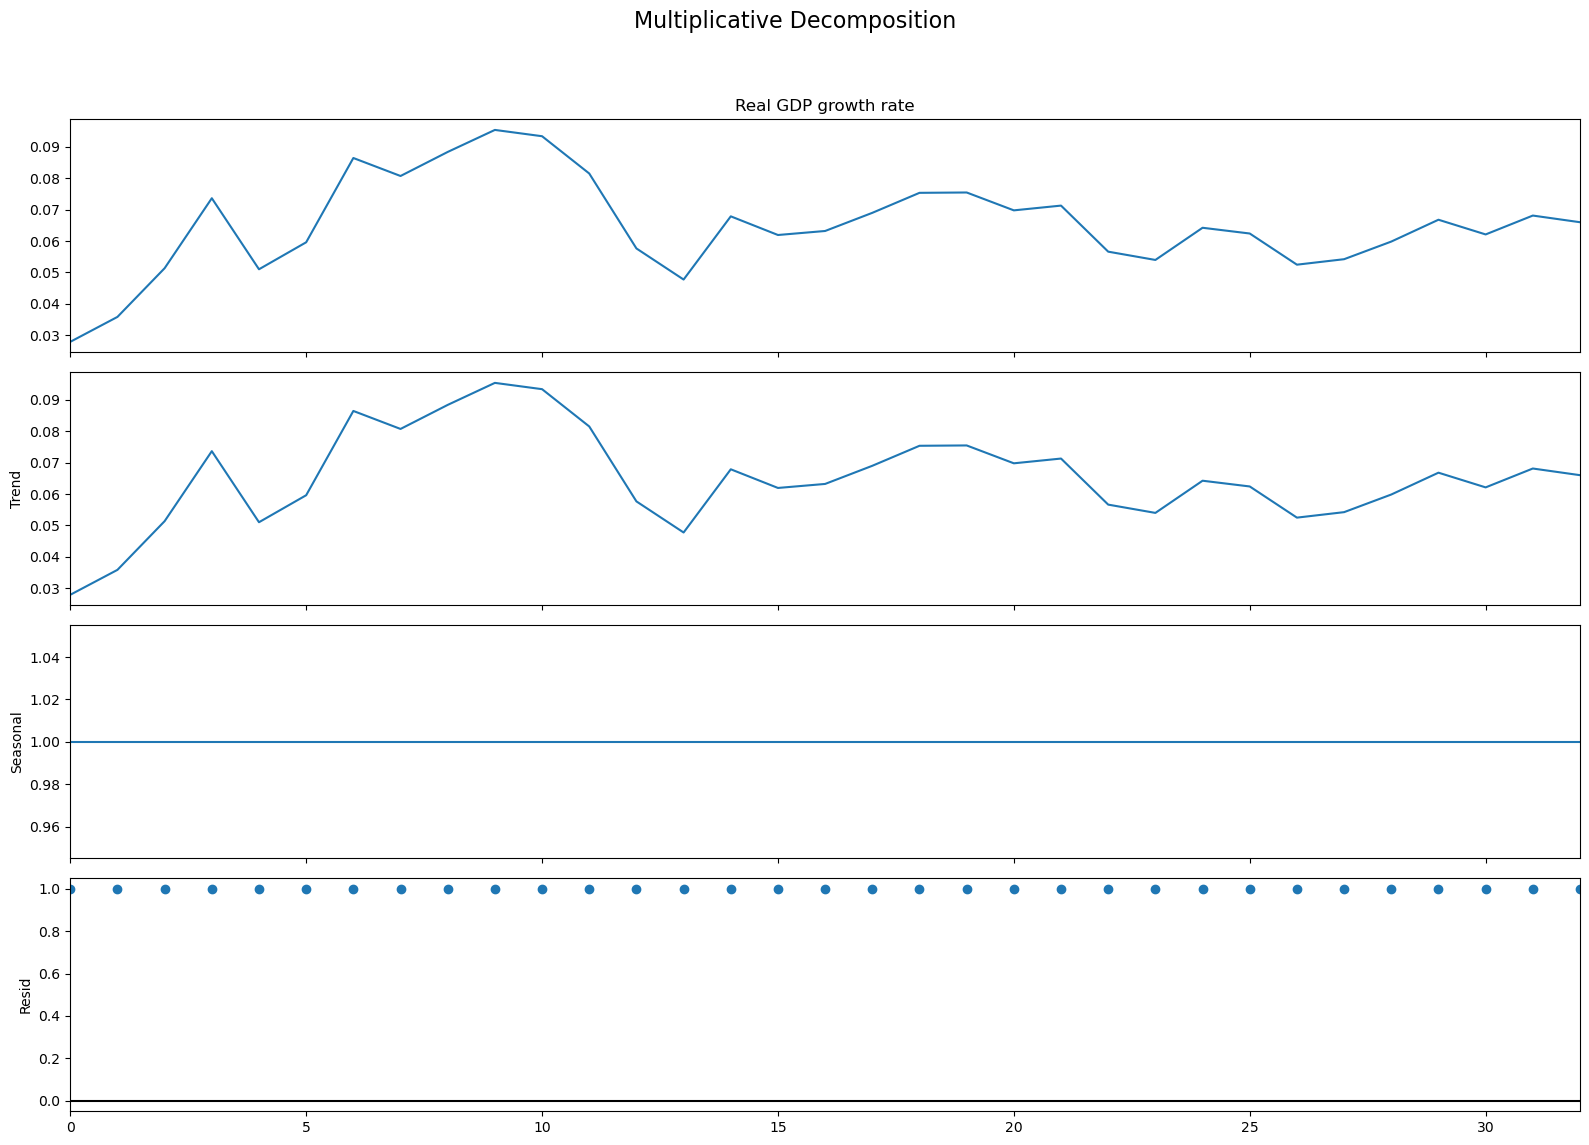

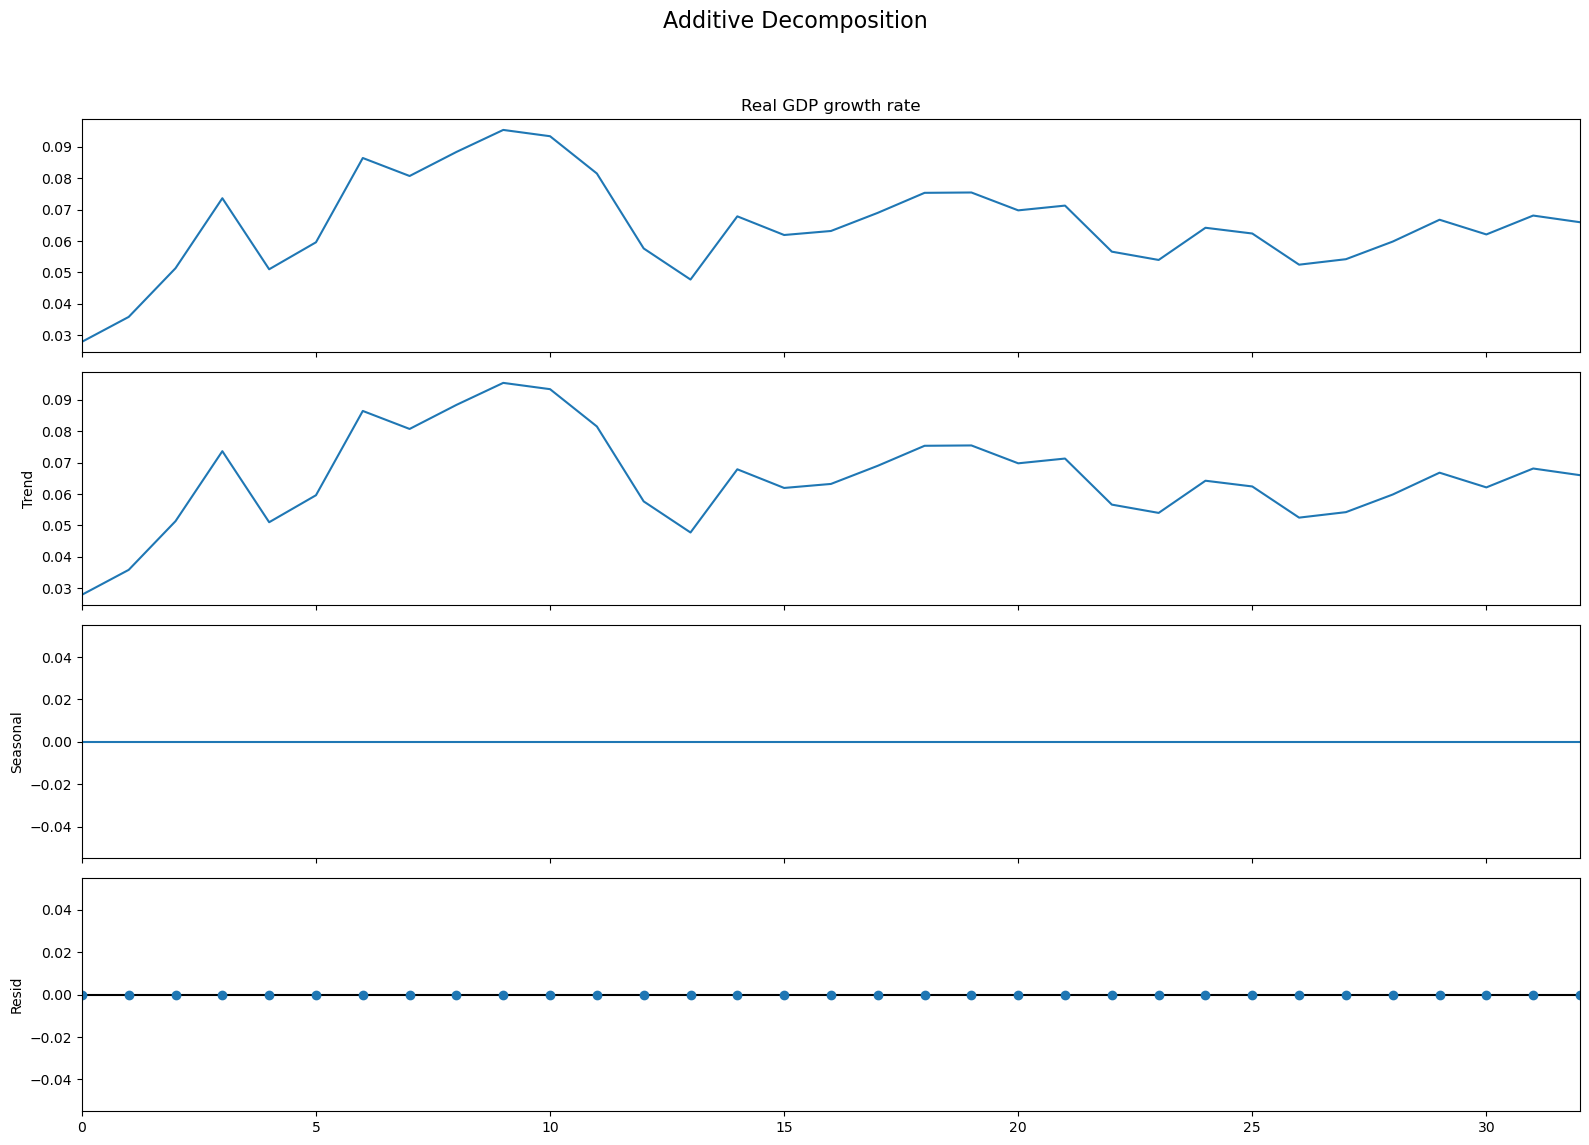

In [17]:
multiplicative_decomposition = seasonal_decompose(df['Real GDP growth rate'], model='multiplicative', period=1)
additive_decomposition = seasonal_decompose(df['Real GDP growth rate'], model='addictive', period=1)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Hypothesis testing

In [66]:
adfuller_test = adfuller(df['Real GDP growth rate'], regression='ct', autolag='AIC')
print(adfuller_test)

(-4.283305055855202, 0.003339459778681824, 8, 24, {'1%': -4.395041166087963, '5%': -3.6123930960648147, '10%': -3.243216493055556}, -153.11113173746693)


The p value is 0.003 so we reject the null hypothesis and conclude that the sequnece do not have unit root, stationary and the sequence is not random. We can choose I =1

For this sequence, which have timestep is 20, we do not use FFT to transform the sequence

In [76]:
acf_test = acf(df['Real GDP growth rate'], nlags=5, alpha = 0.95,qstat=True)
print(acf_test)

(array([ 1.        ,  0.6103412 ,  0.25590371,  0.13018682,  0.02425991,
       -0.22021945]), array([[ 1.        ,  1.        ],
       [ 0.59942535,  0.62125705],
       [ 0.24148391,  0.27032352],
       [ 0.11523567,  0.14513798],
       [ 0.00917429,  0.03934553],
       [-0.23530972, -0.20512918]]), array([13.44551311, 15.88542121, 16.53794266, 16.56138292, 18.56186783]), array([0.00024559, 0.00035524, 0.00087947, 0.00235137, 0.00231873]))


The return pvalue of Ljung-Box(last array) test show that we can reject the null hypothesis and conclude that the residual in timestep [1,5] is white noise. 

- The 1st array denote the ACF value (phi) while 2nd value denote the conf for phi value. 
- The 3rd array denote the p value of the Ljung-Box test. 
- The 4th array denote the conf for the p value of the Ljung-Box test.

In [72]:
pacf_test = pacf(df['Real GDP growth rate'], nlags=5, alpha = 0.95)
print(pacf_test)

(array([ 1.        ,  0.62941436, -0.20493725,  0.1133946 , -0.13387317,
       -0.37345362]), array([[ 1.        ,  1.        ],
       [ 0.61849851,  0.64033021],
       [-0.2158531 , -0.1940214 ],
       [ 0.10247875,  0.12431045],
       [-0.14478902, -0.12295732],
       [-0.38436947, -0.36253777]]))


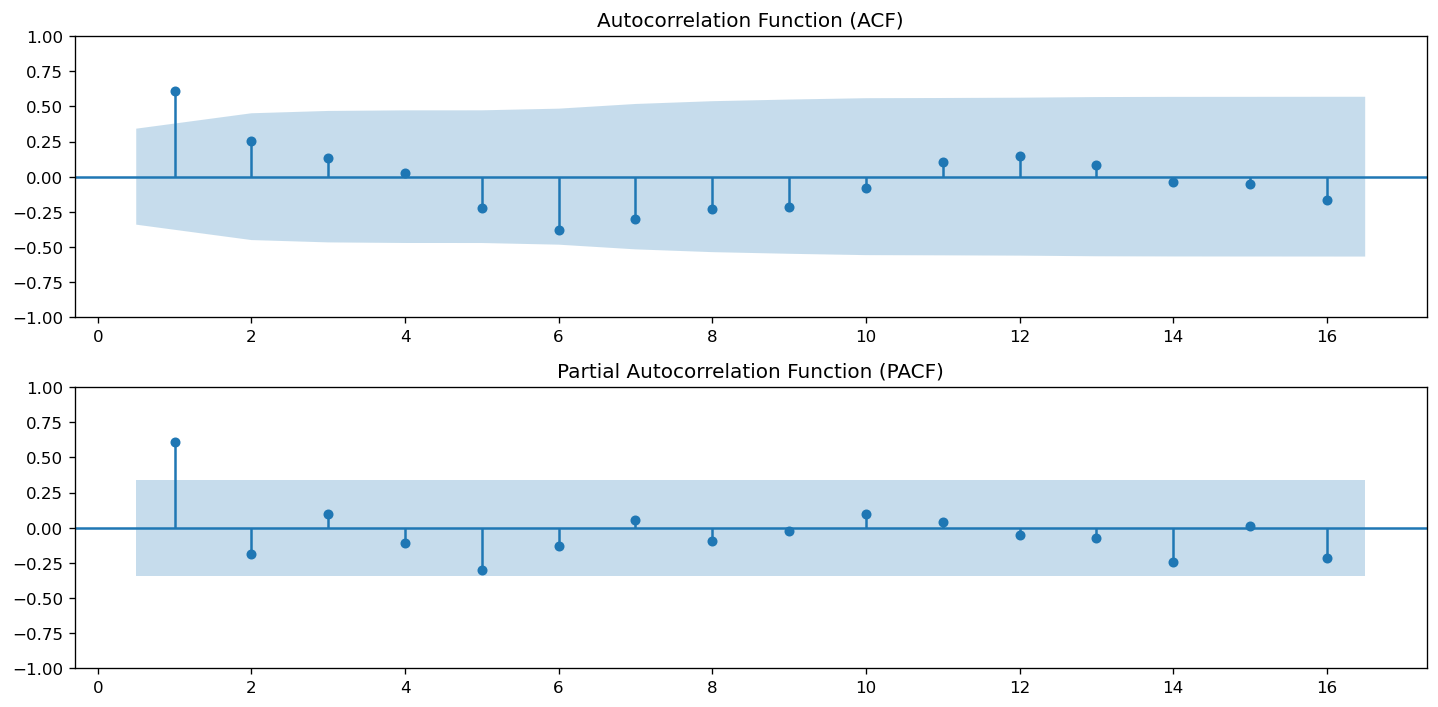

In [70]:
gdp_growth_rate = df['Real GDP growth rate']
plt.figure(figsize=(12, 6))

# Autocorrelation plot
plt.subplot(2, 1, 1)
plot_acf(gdp_growth_rate, lags=16, ax=plt.gca(), zero=False)
plt.title('Autocorrelation Function (ACF)')

# Partial Autocorrelation plot
plt.subplot(2, 1, 2)
plot_pacf(gdp_growth_rate, lags=16, ax=plt.gca(), method='ywm', zero=False)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


From this plot, we can clearly see that MA = 1 and AR = 1 are the best parameters for the ARIMA model. We can also see that the p-value is less than 0.05, so we can reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
model = ARIMA(gdp_growth_rate, order=(1, 1, 1))
fitted_model = model.fit()

forecast_years = [2019, 2020, 2021]
forecast = fitted_model.get_forecast(steps=3)
forecast_values = forecast.predicted_mean

crisis_adjustment = 0.5 
forecast_values_adjusted = forecast_values.copy()
forecast_values_adjusted.iloc[0] *= crisis_adjustment

# Prepare the results
forecast_results = pd.DataFrame({
    "Year": forecast_years,
    "Forecasted GDP Growth Rate": np.round(forecast_values_adjusted, 2)
})



/opt/anaconda3/envs/aio_2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/aio_2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/aio_2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/aio_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWar

In [51]:
forecast_results

,Year,Forecasted GDP Growth Rate
33,2019,0.03
34,2020,0.07
35,2021,0.06
